# [예측모델 - Solution] 

## - ARIMA 
## - Seasonal ARIMA (SARIMA)

### 1. 모듈 불러오기

In [ ]:
# !git clone https://github.com/Jiyoon52/LG_time_series_day02_dataset.git

In [23]:
#!pip install pmdarima

import os

import numpy as np
import pandas as pd

import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima

import seaborn as sns
import itertools

import warnings
warnings.filterwarnings(action='ignore') 

%matplotlib inline

### 2. 데이터 불러오기

### Wisconsin Employment Data
### 미국 위스콘신주의 취업건수(Employment) 예측을 위한 예측모델 학습


In [2]:
data = pd.read_csv('data/Employment.csv')
# data = pd.read_csv('/content/LG_time_series_day02_dataset/data/Employment.csv')
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,employment
month,
1961-01-01,239.6
1961-02-01,236.4
1961-03-01,236.8
1961-04-01,241.5
1961-05-01,243.7
...,...
1975-06-01,394.6
1975-07-01,394.0
1975-08-01,397.0


### 3. Box-Jenkins ARIMA Procedure
-  3.1 Data Preprocessing
-  3.2 Identify Model to be Tentatively Entertainted
-  3.3 Estimate Parameters
-  3.4 Diagnosis Check
-  3.5 use Model to Forecast

### 3.1 Data Preprocessing

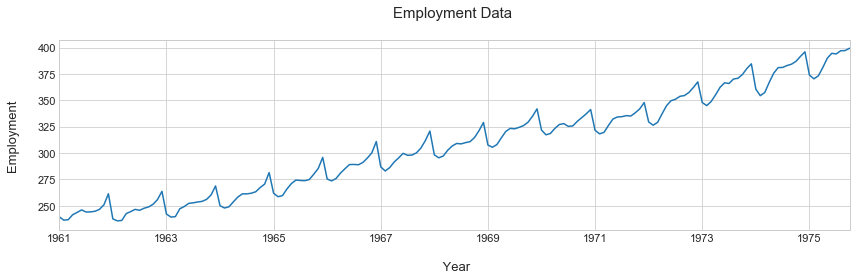

In [3]:
data.plot(figsize=(12,4))

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend('')

plt.title('Employment Data \n', fontsize=15)
plt.xlabel('\n Year', fontsize=13)
plt.ylabel('Employment \n', fontsize=13)
plt.tight_layout()
plt.show()

### Q: 시계열 분해 수행(Trend, Seasonal, Residual 그래프 확인하기)

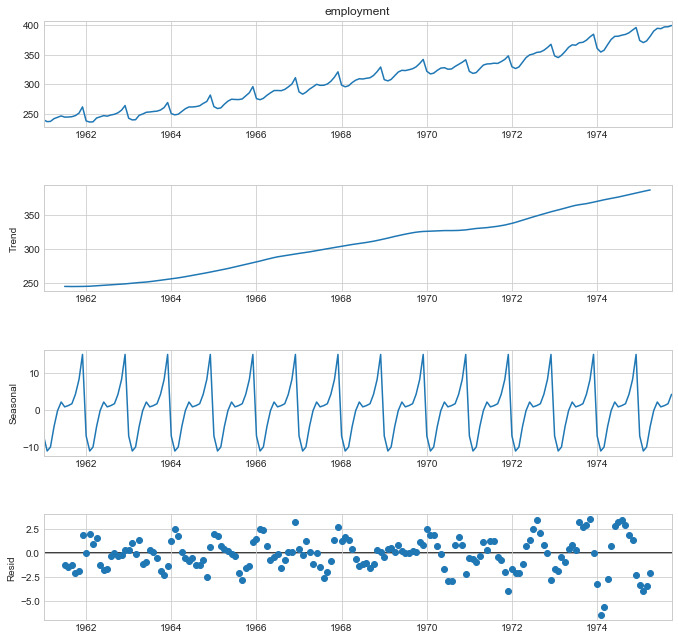

In [4]:
decomposition = sm.tsa.seasonal_decompose(data['employment'],  model='additive')

fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

### 3.2 Identify Model to be Tentatively Entertainted

### Q : 학습 데이터와 테스트 데이터 분리 - train:test = 8:2 로 분리하기

In [5]:
train, test = train_test_split(data, test_size=0.2, shuffle=False)

### Q : Autocorrelation , Partial Autocorrelation 확인하기

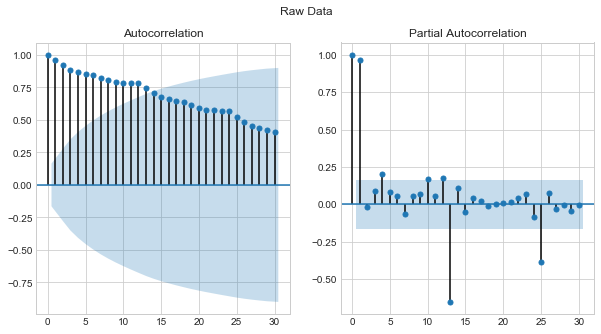

In [6]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=30, ax=ax[1]);

### Q : 차분(first difference) 후 null 값 제거하기

In [7]:
diff_train = train.copy()
diff_train = diff_train['employment'].diff()
diff_train = diff_train.dropna()
print('####### Raw Data #######')
print(train)
print('### Differenced Data ###')
print(diff_train)

####### Raw Data #######
            employment
month                 
1961-01-01       239.6
1961-02-01       236.4
1961-03-01       236.8
1961-04-01       241.5
1961-05-01       243.7
...                ...
1972-06-01       349.6
1972-07-01       351.0
1972-08-01       353.8
1972-09-01       354.5
1972-10-01       357.4

[142 rows x 1 columns]
### Differenced Data ###
month
1961-02-01   -3.2
1961-03-01    0.4
1961-04-01    4.7
1961-05-01    2.2
1961-06-01    2.4
             ... 
1972-06-01    4.7
1972-07-01    1.4
1972-08-01    2.8
1972-09-01    0.7
1972-10-01    2.9
Name: employment, Length: 141, dtype: float64


### Q : 그래프로 차분 전후 비교하기

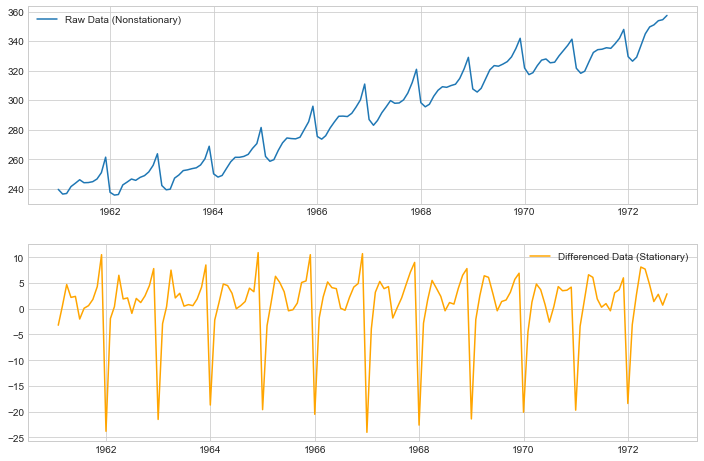

In [8]:
plt.figure(figsize=(12,8))

plt.subplot(211)
plt.plot(train['employment'])
plt.legend(['Raw Data (Nonstationary)'])

plt.subplot(212)
plt.plot(diff_train,'orange')
plt.legend(['Differenced Data (Stationary)'])

plt.show()

### Q : 차분 후 Autocorrelation , Partial Autocorrelation 확인하기

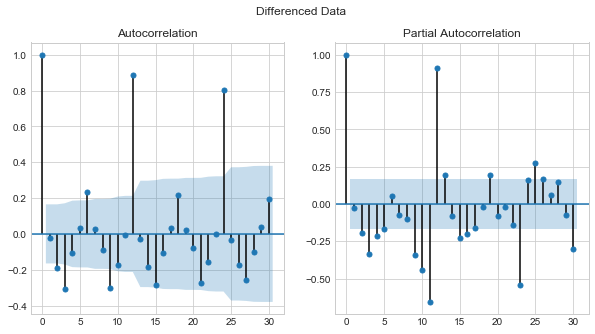

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train.values.squeeze(), lags=30, ax=ax[1]);

### 3.3 Estimate Parameters
### Q : 파라미터 조합 (1, 1, 0)으로 모델 학습 후 학습 결과 (Summary) 확인하기

In [11]:
ARIMA = sm.tsa.arima.ARIMA

ARIMA_model = ARIMA(train.values, order=(1,1,0))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  142
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -476.765
Date:                Wed, 12 Jan 2022   AIC                            957.530
Time:                        20:41:00   BIC                            963.427
Sample:                             0   HQIC                           959.926
                                - 142                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0096      0.146     -0.066      0.948      -0.295       0.276
sigma2        50.6399      7.267      6.968      0.000      36.396      64.884
===================================================================================
Ljung-Box (Q):                      492.55   Jarque-Bera (JB):               222.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -2.12
Prob(H) (two-sided):                  0.72   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.4.1 Diagnosis Check - ARIMA
### Q : ARIMA 모델 파라미터 탐색 범위 설정하기
 - p : 0 ~ 2
 - d : 1 ~ 3
 - q : 0 ~ 2

In [34]:
print('Examples of parameter combinations for ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
print(pdq)

Examples of parameter combinations for ARIMA...
[(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]


### Q : 설정된  각 파라미터 조합으로 모델 학습하며 파라미터 조합마다 AIC 값 저장하기

In [24]:
aic=[]
for i in pdq:
    model = ARIMA(train.values, order=(i))
    ARIMA_model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(ARIMA_model_fit.aic,2)}')
    aic.append(round(ARIMA_model_fit.aic,2))

ARIMA: (0, 1, 0) >> AIC : 955.54
ARIMA: (0, 1, 1) >> AIC : 957.52
ARIMA: (0, 1, 2) >> AIC : 949.99
ARIMA: (0, 1, 3) >> AIC : 943.59
ARIMA: (0, 2, 0) >> AIC : 1047.98
ARIMA: (0, 2, 1) >> AIC : 954.78
ARIMA: (0, 2, 2) >> AIC : 956.72
ARIMA: (0, 2, 3) >> AIC : 938.18
ARIMA: (1, 1, 0) >> AIC : 957.53
ARIMA: (1, 1, 1) >> AIC : 949.94
ARIMA: (1, 1, 2) >> AIC : 947.21
ARIMA: (1, 1, 3) >> AIC : 945.58
ARIMA: (1, 2, 0) >> AIC : 1023.28
ARIMA: (1, 2, 1) >> AIC : 956.74
ARIMA: (1, 2, 2) >> AIC : 948.15
ARIMA: (1, 2, 3) >> AIC : 947.9
ARIMA: (2, 1, 0) >> AIC : 955.22
ARIMA: (2, 1, 1) >> AIC : 944.02
ARIMA: (2, 1, 2) >> AIC : 908.43
ARIMA: (2, 1, 3) >> AIC : 904.81
ARIMA: (2, 2, 0) >> AIC : 1017.05
ARIMA: (2, 2, 1) >> AIC : 953.91
ARIMA: (2, 2, 2) >> AIC : 949.18
ARIMA: (2, 2, 3) >> AIC : 945.18
ARIMA: (3, 1, 0) >> AIC : 943.7
ARIMA: (3, 1, 1) >> AIC : 941.54
ARIMA: (3, 1, 2) >> AIC : 905.75
ARIMA: (3, 1, 3) >> AIC : 896.81
ARIMA: (3, 2, 0) >> AIC : 1001.27
ARIMA: (3, 2, 1) >> AIC : 940.47
ARIMA: (

### Q : AIC 값이 가장 작은 최적의 파라미터 조합 찾기

In [25]:
ARIMA_optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
ARIMA_optimal

[((3, 1, 3), 896.81)]

### 가장 좋은 모델(최적 모델) 학습 결과 (Summary) 확인하기

In [26]:
ARIMA_model_opt = ARIMA(train.values, order=ARIMA_optimal[0][0])
ARIMA_model_opt_fit = ARIMA_model_opt.fit()

ARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  142
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -441.407
Date:                Wed, 12 Jan 2022   AIC                            896.814
Time:                        20:59:55   BIC                            917.455
Sample:                             0   HQIC                           905.202
                                - 142                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0020      0.010      0.191      0.848      -0.018       0.022
ar.L2          0.0037      0.016      0.239      0.811      -0.027       0.034
ar.L3         -0.9964      0.013    -78.923      0.000      -1.021      -0.972
ma.L1         -0.0826      0.338     -0.244      0.807      -0.745       0.580
ma.L2         -0.0628      0.306     -0.205      0.837      -0.663       0.537
ma.L3          0.9795      0.599      1.636      0.102      -0.194       2.153
sigma2        29.0325     18.524      1.567      0.117      -7.274      65.339
===================================================================================
Ljung-Box (Q):                      472.72   Jarque-Bera (JB):                99.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.51
Prob(H) (two-sided):                  0.99   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5.1 Use Model to Forecast - ARIMA
### Q : 성능이 가장 좋은 모델로 미래 시점 예측 후 R-squared 계산하기

In [27]:
ARIMA_prediction = ARIMA_model_opt_fit.forecast(len(test))
ARIMA_test_pred = ARIMA_prediction
forecast = ARIMA_model_opt_fit.get_forecast(steps = len(test))
forecasts_and_intervals = forecast.summary_frame()
forecasts_and_intervals

ARIMA_test_ub = forecasts_and_intervals['mean_ci_upper']
ARIMA_test_lb = forecasts_and_intervals['mean_ci_lower']
predict_index = list(test.index)
r2 = r2_score(test, ARIMA_test_pred)

# ARIMA_prediction = ARIMA_model_opt_fit.forecast(len(test))
# ARIMA_test_pred = ARIMA_prediction[0]
# ARIMA_test_ub = ARIMA_prediction[2][:,0]
# ARIMA_test_lb = ARIMA_prediction[2][:,1]
# predict_index = list(test.index)

### 모델 성능 확인하기

In [28]:
print('ARIMA')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')

ARIMA
------------------------------
MSE: 542.77
RMSE: 23.3
MAE: 19.26
R2 score: -1.41


### Q : 실제값과 예측값 그래프로 비교하기

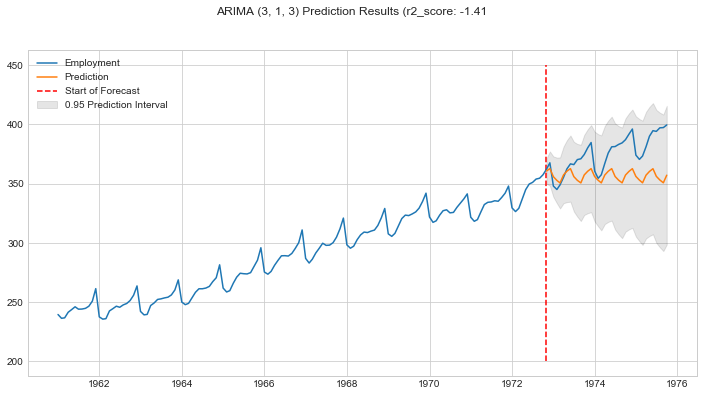

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Employment')
ax.plot(predict_index, ARIMA_test_pred, label = 'Prediction')
ax.vlines(datetime.datetime.strptime('1972-11-01','%Y-%m-%d'), 200, 450, linestyle='--', color='r', label='Start of Forecast')
ax.fill_between(predict_index, ARIMA_test_lb, ARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {ARIMA_optimal[0][0]} Prediction Results (r2_score: {np.round(r2_score(test, ARIMA_test_pred), 2)}')
plt.show()

### 3.4.2 Diagnosis Check - SARIMA
### Q : SARIMA 모델 파라미터 탐색 범위 설정하기
 - p : 0 ~ 2
 - d : 1
 - q : 0 ~ 2
 - s : 12

In [35]:
print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(seasonal_pdq)

Examples of parameter combinations for Seasonal ARIMA...
[(0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12)]


### Q : 설정된  각 파라미터 조합으로 모델 학습하며 파라미터 조합마다 AIC 값 저장하기

In [36]:
aic=[]
params=[]
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train.values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))  
        except:
            continue

SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 456.16
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 449.2
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 446.66
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 451.86
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 446.51
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 448.32
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 450.51
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 448.31
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 450.04
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 454.94
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 448.88
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 446.09
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 451.34
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 445.97
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 447.71
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 450.1
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 447.68
SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : 449.34
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 456.9
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 450.88
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 448.06
SARIMA: (0, 1, 2

### AIC 값이 가장 작은 최적의 파라미터 조합 찾기

In [37]:
SARIMA_optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
SARIMA_optimal

[(((1, 1, 0), (1, 1, 1, 12)), 445.83)]

### Q : 가장 좋은 모델(최적 모델) 학습 결과 (Summary) 확인하기

In [38]:
SARIMA_model_opt = SARIMAX(train.values, order=SARIMA_optimal[0][0][0], seasonal_order = SARIMA_optimal[0][0][1])
SARIMA_model_opt_fit = SARIMA_model_opt.fit()

SARIMA_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -218.913
Date:                              Wed, 12 Jan 2022   AIC                            445.826
Time:                                      21:14:19   BIC                            457.265
Sample:                                           0   HQIC                           450.474
                                              - 142                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1439      0.090      1.591      0.112      -0.033       0.321
ar.S.L12       0.4458      0.228      1.954      0.051      -0.001       0.893
ma.S.L12      -0.8002      0.207     -3.858      0.000      -1.207      -0.394
sigma2         1.6863      0.215      7.837      0.000       1.265       2.108
===================================================================================
Ljung-Box (Q):                       31.01   Jarque-Bera (JB):                 4.38
Prob(Q):                              0.85   Prob(JB):                         0.11
Heteroskedasticity (H):               1.51   Skew:                            -0.39
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5.2 Use Model to Forecast - SARIMA
### Q : 성능이 가장 좋은 모델로 미래 시점 예측 후 R-squared 계산하기

In [39]:
SARIMA_prediction = SARIMA_model_opt_fit.get_forecast(len(test))
SARIMA_test_pred = SARIMA_prediction.predicted_mean
SARIMA_test_ub = SARIMA_prediction.conf_int()[:,0]
SARIMA_test_lb = SARIMA_prediction.conf_int()[:,1]
predict_index = list(test.index)

### 모델 성능 확인하기

In [40]:
print('SARIMA')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, SARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,SARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, SARIMA_test_pred), 2)}')

SARIMA
------------------------------
MSE: 5.54
RMSE: 2.35
MAE: 1.82
R2 score: 0.98


### 실제값과 예측값 그래프로 비교하기

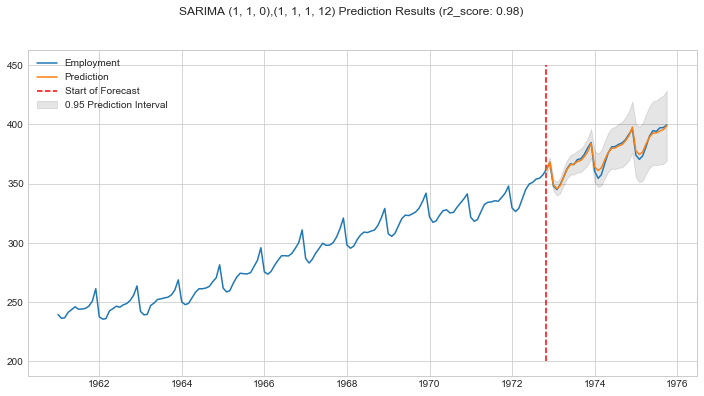

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Employment')
ax.plot(predict_index, SARIMA_test_pred, label = 'Prediction')
ax.vlines(datetime.datetime.strptime('1972-11-01','%Y-%m-%d'), 200, 450, linestyle='--', color='r', label='Start of Forecast')
ax.fill_between(predict_index, SARIMA_test_lb, SARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {SARIMA_optimal[0][0][0]},{SARIMA_optimal[0][0][1]} Prediction Results (r2_score: {np.round(r2_score(test, SARIMA_test_pred), 2)})')
plt.show()

### 3.4.3 Diagnosis Check - auto_arima
### Q : auto_arima 모델 파라미터 탐색 범위 설정 후 모델 학습하기

In [42]:
auto_arima_model = auto_arima(train, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1, 
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=456.155, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=449.197, Time=0.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=446.660, Time=0.22 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=448.489, Time=0.42 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=451.857, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=446.512, Time=0.14 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=448.318, Time=0.40 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=450.317, Time=1.30 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=450.506, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=448.307, Time=0.59 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=450.039, Time=0.69 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=3.57 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=452.299, Time=0.20 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=450.204, Time=1.15 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=452.019, Time=2.02 sec
 ARIMA(0,1,1)(

### Q : 모델 학습 후 학습 결과 (Summary) 확인하기

In [43]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -218.913
Date:                              Wed, 12 Jan 2022   AIC                            445.826
Time:                                      21:15:11   BIC                            457.265
Sample:                                           0   HQIC                           450.474
                                              - 142                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1439      0.090      1.591      0.112      -0.033       0.321
ar.S.L12       0.4458      0.228      1.954      0.051      -0.001       0.893
ma.S.L12      -0.8002      0.207     -3.858      0.000      -1.207      -0.394
sigma2         1.6863      0.215      7.837      0.000       1.265       2.108
===================================================================================
Ljung-Box (Q):                       31.01   Jarque-Bera (JB):                 4.38
Prob(Q):                              0.85   Prob(JB):                         0.11
Heteroskedasticity (H):               1.51   Skew:                            -0.39
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5.3 Use Model to Forecast - auto_arima
### Q : auto_arima를 통해 선정된 성능이 가장 좋은 모델로 미래 시점 예측 후 R-squared 계산하기

In [44]:
AUTO_ARIMA_prediction = auto_arima_model.predict(len(test), return_conf_int=True)
AUTO_ARIMA_test_pred = AUTO_ARIMA_prediction[0]
AUTO_ARIMA_test_ub = AUTO_ARIMA_prediction[1][:,0]
AUTO_ARIMA_test_lb = AUTO_ARIMA_prediction[1][:,1]
predict_index = list(test.index)

### 모델 성능 확인하기

In [45]:
print('AUTO ARIMA')
print('-'*30)
print(f'MSE: {np.round(mean_squared_error(test, AUTO_ARIMA_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test,AUTO_ARIMA_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, AUTO_ARIMA_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, AUTO_ARIMA_test_pred), 2)}')

AUTO ARIMA
------------------------------
MSE: 5.54
RMSE: 2.35
MAE: 1.82
R2 score: 0.98


### Q : 실제값과 예측값 그래프로 비교하기

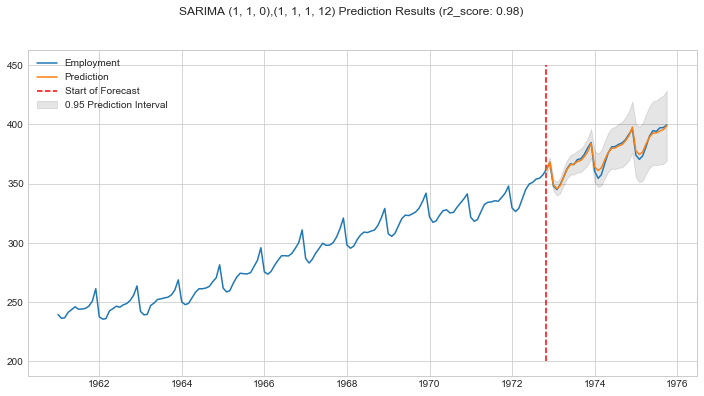

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data.values, label = 'Employment')
ax.plot(predict_index, AUTO_ARIMA_test_pred, label = 'Prediction')
ax.vlines(datetime.datetime.strptime('1972-11-01','%Y-%m-%d'), 200, 450, linestyle='--', color='r', label='Start of Forecast')
ax.fill_between(predict_index, AUTO_ARIMA_test_lb, AUTO_ARIMA_test_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order} Prediction Results (r2_score: {np.round(r2_score(test, AUTO_ARIMA_test_pred), 2)})')
plt.show()

# EOD